# 0.0 IMPORTS

In [1]:
!pip install matplotlib

cryptography 3.3.1 has requirement cffi>=1.12, but you'll have cffi 1.11.5 which is incompatible.
You are using pip version 10.0.1, however version 21.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd

import inflection

import math

import datetime

import numpy as np

import seaborn as sns

from matplotlib import pyplot as plt

from IPython.display import Image

import matplotlib.pyplot as plt
plt.style.use("ggplot")

## 0.1 Helper Functions

## 0.2 Loading data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory= False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
678214,1080,5,2013-11-01,0,0,0,0,a,0,a,a,2410.0,NaN,NaN,1,40.0,2014.0,"Jan,Apr,Jul,Oct"


# 1.0 PASSO 1 - DESCRICAO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print ('Number of Rows: {}'.format (df1.shape[0]))
print ('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [8]:
df1['date']= pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan (x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan (x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6:'Jun', 7:'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct',11:'Nov',12:'Dec' }

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [11]:
df1.sample(5).T

,1007928,333427,39608,677997,62549
store,754,888,584,863,110
day_of_week,3,5,5,5,5
date,2013-01-09 00:00:00,2014-09-19 00:00:00,2015-06-26 00:00:00,2013-11-01 00:00:00,2015-06-05 00:00:00
sales,8848,8295,4175,9277,4487
customers,1032,777,395,1106,590
open,1,1,1,1,1
promo,1,1,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,c,d,d,a,a


## 1.6 Changes Types

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

In [14]:
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

## 1.7.1 Numerical Attributes

In [16]:
#Central Tendency -mean, median
ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply(np.median)).T

#Dispersion -std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2,d3,d4, ct1, ct2, d1,d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.155231,0.0,0.362124,1.904152,1.625796


Populating the interactive namespace from numpy and matplotlib


C:\Users\vanessa.paula\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


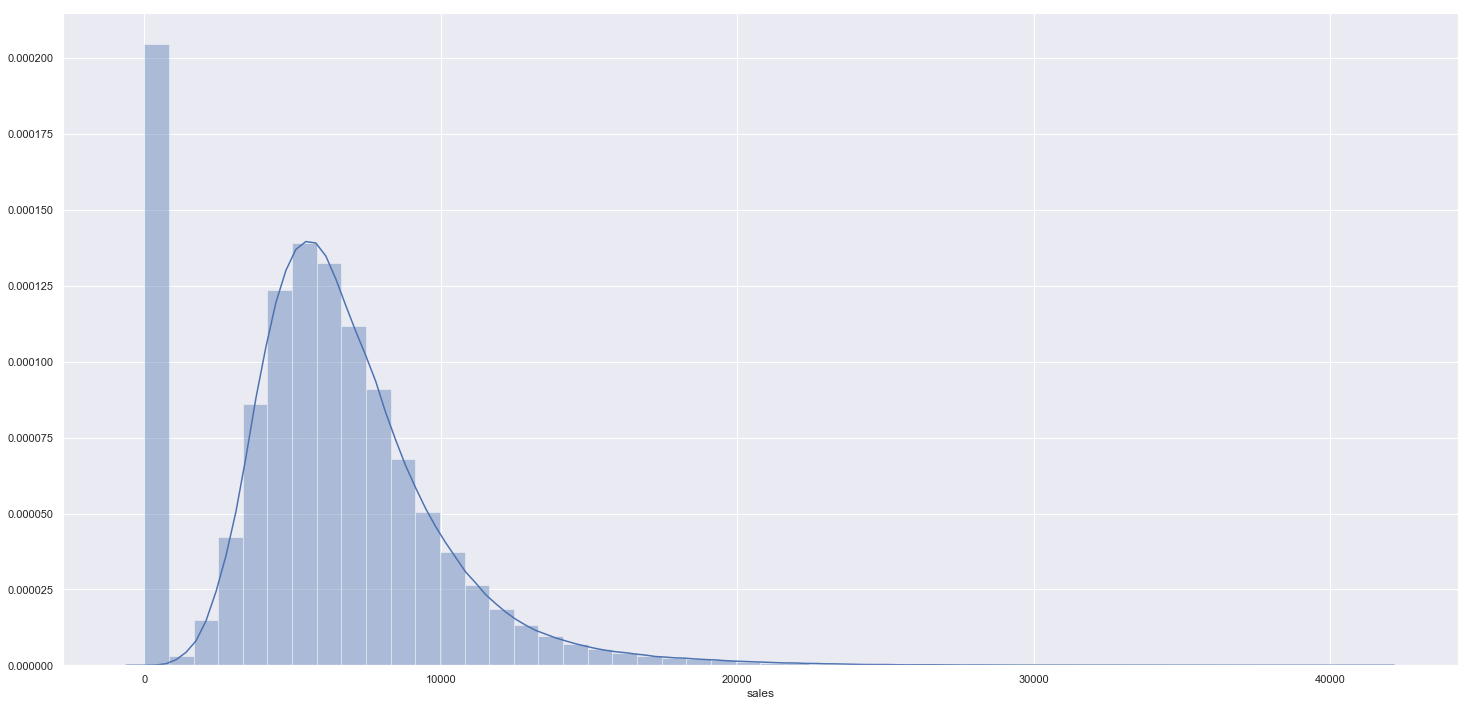

In [18]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()
sns.distplot(df1['sales'])

## 1.7.2 Categorical Attributes

In [19]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     35
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

Populating the interactive namespace from numpy and matplotlib


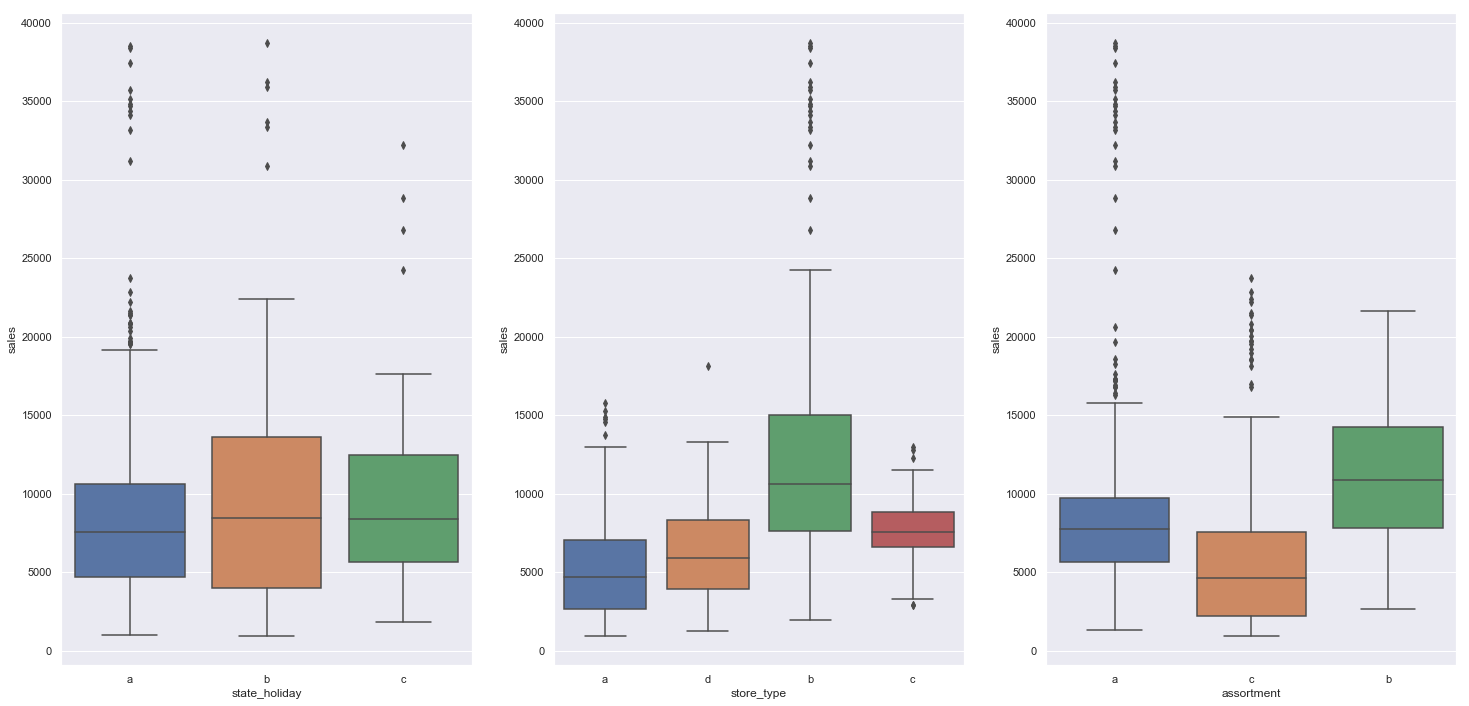

In [23]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.subplot(1,3,1)

sns.boxplot(x = 'state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y='sales', data=aux1)

# 2.0 PASSO 2 - FEATURE ENGINEERING

In [24]:
df2 = df1.copy()

## Mapa Mental das Hipótese

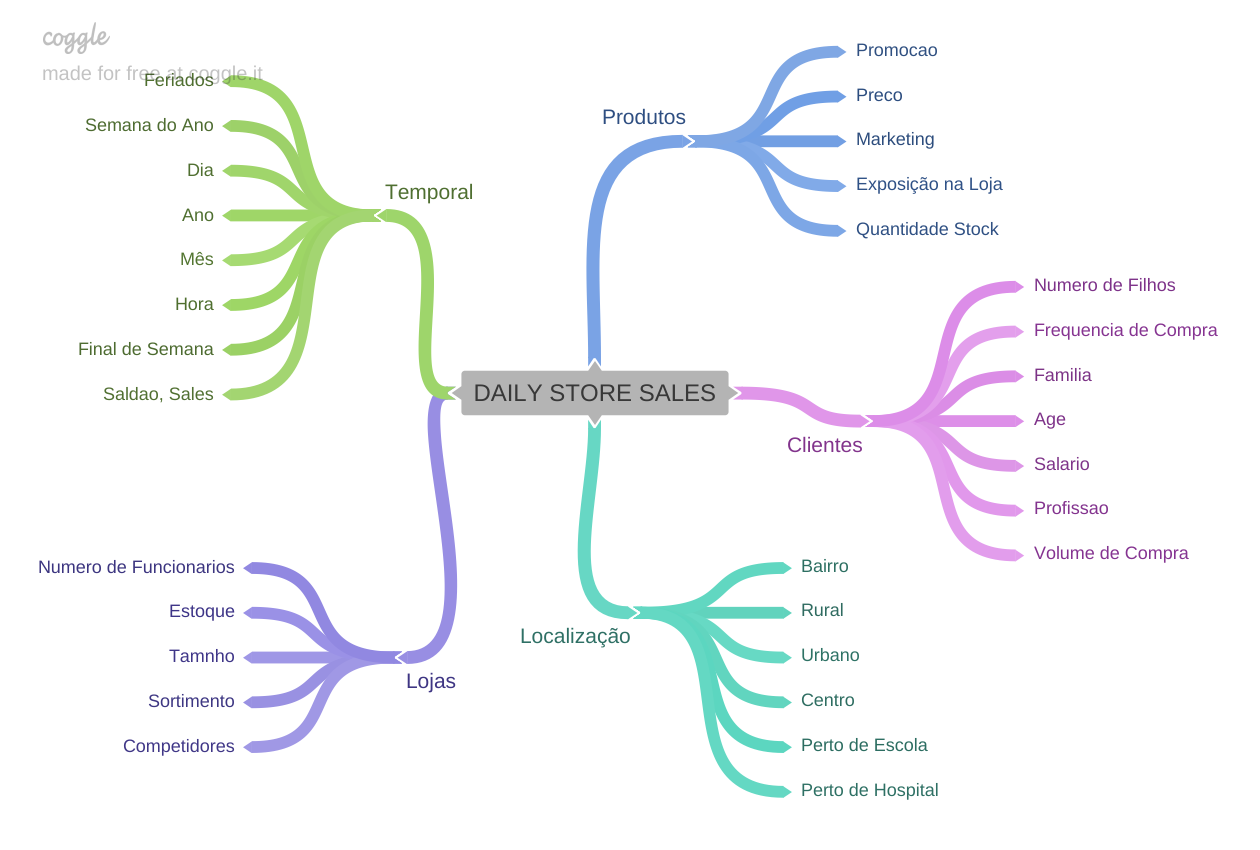

In [22]:
Image('img/MindMapHypothesis.png')

## 2.1 Criação das Hipóteses

## 2.1.1 Hipótese Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tenpo deveriam vender mais.

## 2.1.2 Hipótese Produto

**1.** Lojas que investiam mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoção mais agressivas(descontos maiores), deveriam vender mais.

**5.** Lojas com promoção ativas por tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

## 2.1.3 Hipótese Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tenpo deveriam vender mais.

**4.** Lojas com promoção ativas por tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering 

In [25]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [26]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#compettion since
#df2['competition_since']=pd.Timestamp(df2['competition_since'])
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
#df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w')) - datetime.timedelta(days=7)                              
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int) 

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x== 'a' else 'extra' if x=='b' else 'extended')
                                 
#state holiday
df2['state_holiday']=  df2['state_holiday'].apply(lambda x: 'public holiday' if x=='a'  else 'easter_holiday' if  x=='b' else 'Christmas' if x=='c' else x=='regular_day')

In [27]:
df2['competition_since']=pd.to_datetime(df2['competition_since'], errors = 'coerce')

In [28]:
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days)

In [29]:
df2.sample(5).T

,290873,398778,83396,959998,802622
store,321,774,887,769,608
day_of_week,1,5,1,4,5
date,2014-11-03 00:00:00,2014-07-11 00:00:00,2015-05-18 00:00:00,2013-02-21 00:00:00,2013-07-12 00:00:00
sales,7662,5298,9656,8435,7742
customers,626,701,743,2464,902
open,1,1,1,1,1
promo,1,0,1,1,0
state_holiday,False,False,False,False,False
school_holiday,0,0,0,0,0
store_type,c,a,d,b,a


In [30]:
df2.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week                    0
promo2_since_year                    0
promo_interval                       0
month_map                            0
is_promo                             0
year                                 0
month                                0
day                                  0
week_of_year                         0
year_week                            0
competition_since        

In [32]:
df2['competition_time_month'].max()

1407.0

In [33]:
df2['competition_time_month'] = df2['competition_time_month'].apply(lambda x: '1408' if math.isnan(x) else x)

# 3.0 PASSO 3 - FILTRAGEM DE VARIÁVEIS

In [34]:
df3=df2.copy()

In [35]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,promo_since,promo_time_week,competition_time_month
0,1,5,2015-07-31,5263,555,1,1,False,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,2015-07-27,0,84
1,2,5,2015-07-31,6064,625,1,1,False,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,2010-03-22,279,94
2,3,5,2015-07-31,8314,821,1,1,False,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,2011-03-28,226,105
3,4,5,2015-07-31,13995,1498,1,1,False,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,2015-07-27,0,71
4,5,5,2015-07-31,4822,559,1,1,False,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,2015-07-27,0,4


## 3.1 Filtragem das Linhas

In [36]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Selecao das Colunas

In [37]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [38]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since', 'promo_since',
       'promo_time_week', 'competition_time_month'],
      dtype='object')

# 4.0 PASSO 4 - Análise Exploratória dos Dados

In [39]:
df4 = df3.copy()

## 4.1 Análise Univarada

### 4.1.1 Response Variable

In [48]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\vanessa.paula\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


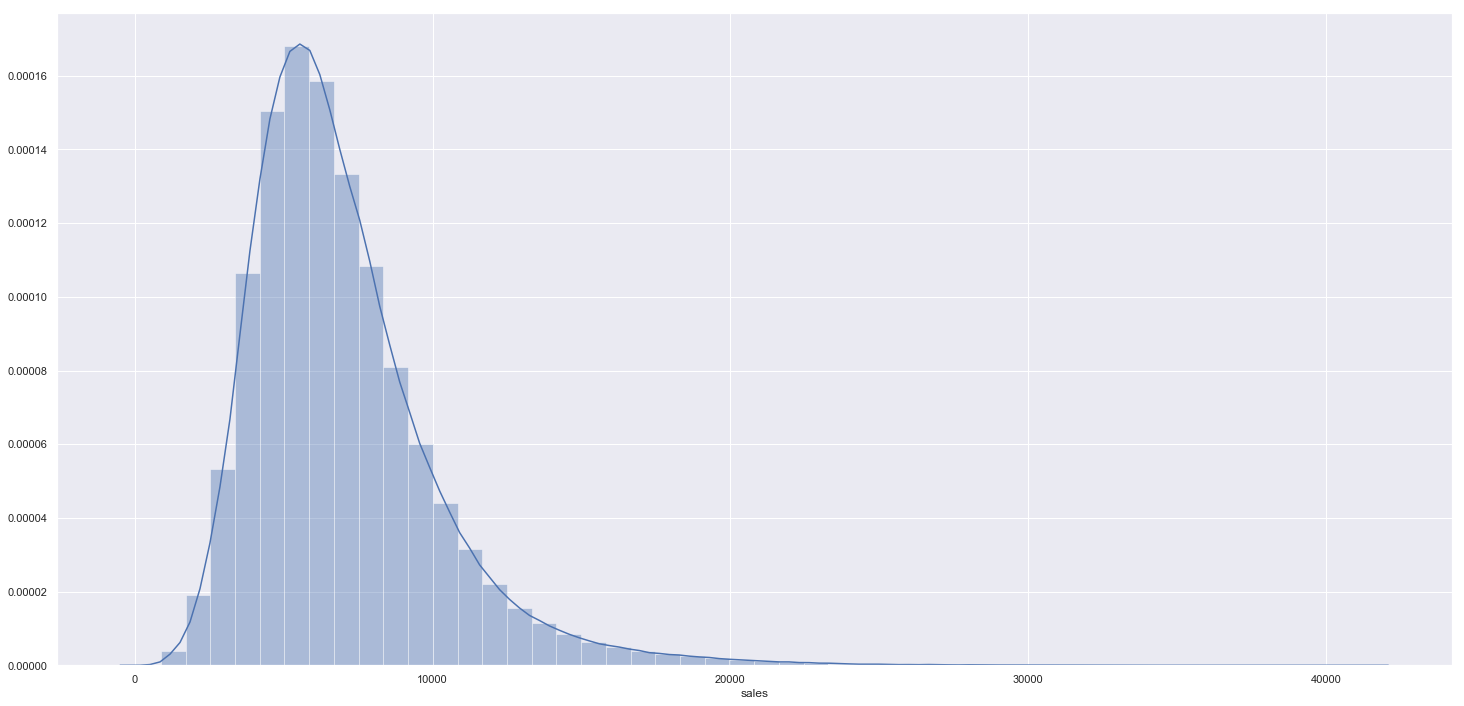

In [43]:
sns.distplot((df4['sales']))

### 4.1.2 Numerical Variable

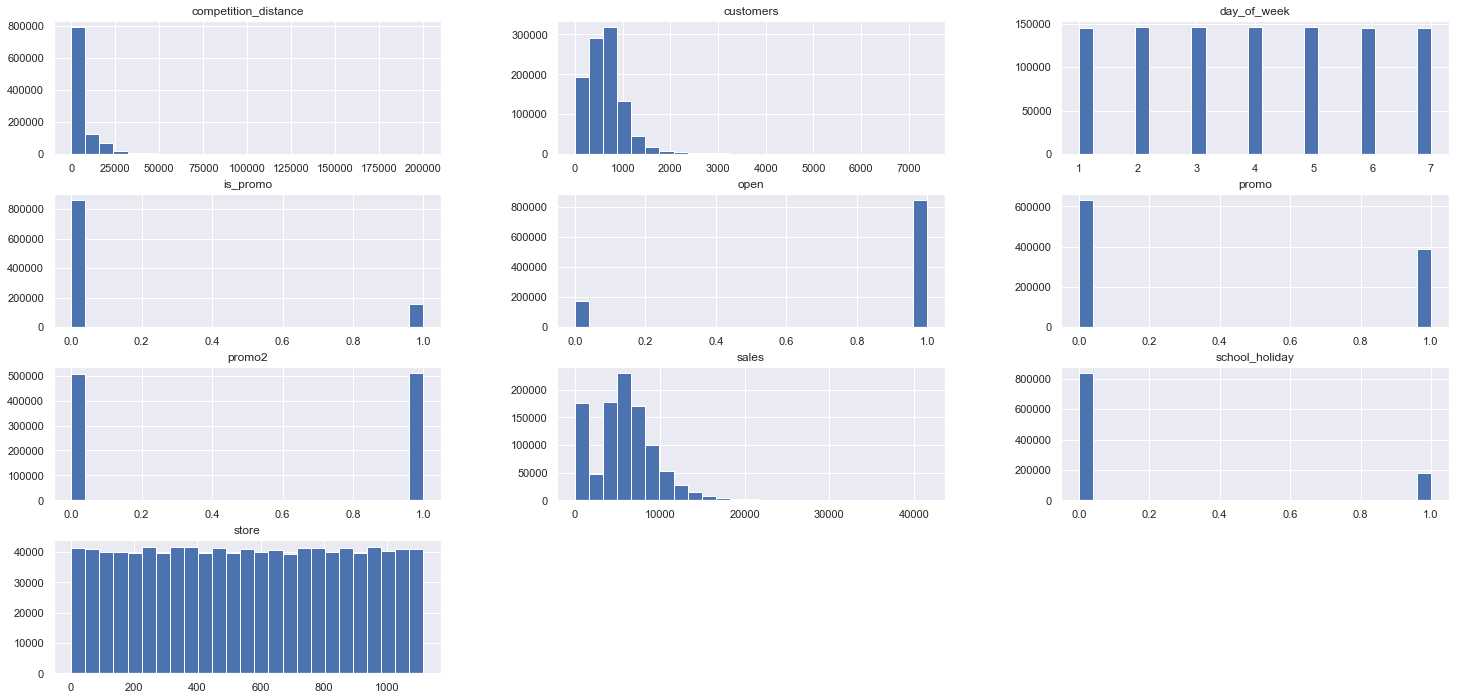

In [44]:
num_attributes.hist(bins = 25);

### 4.1.3 Categorical Variable

In [45]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

C:\Users\vanessa.paula\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


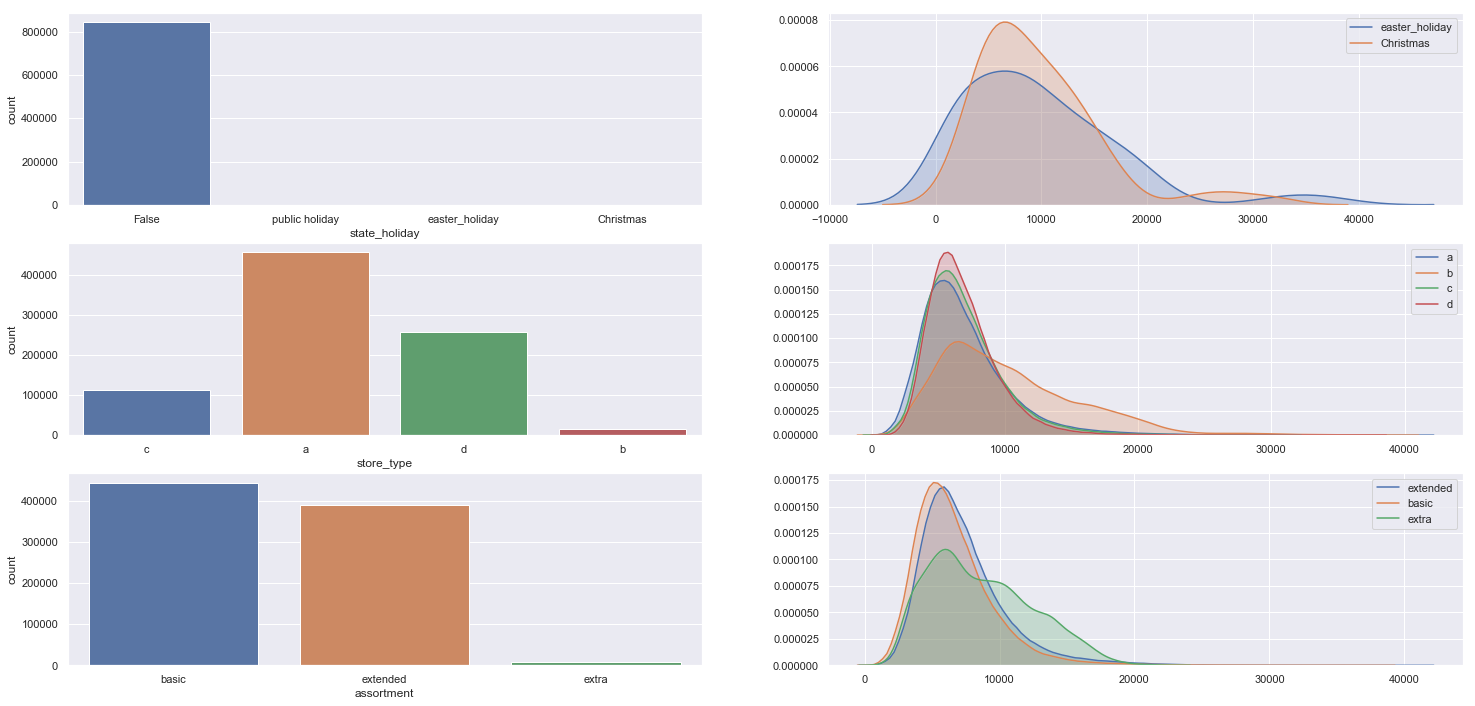

In [54]:
#state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday']=='Christmas']['sales'], label='Christmas', shade=True)

#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type']=='b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type']=='c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type']=='d']['sales'], label='d', shade=True)

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='extended']['sales'], label = 'extended', shade=True)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'], label = 'basic', shade=True)
sns.kdeplot(df4[df4['assortment']=='extra']['sales'], label = 'extra', shade=True)

## 4.2 Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais.
**Falsa** - Lojas com MAIOR SORTIMENTO vendem MENOS.

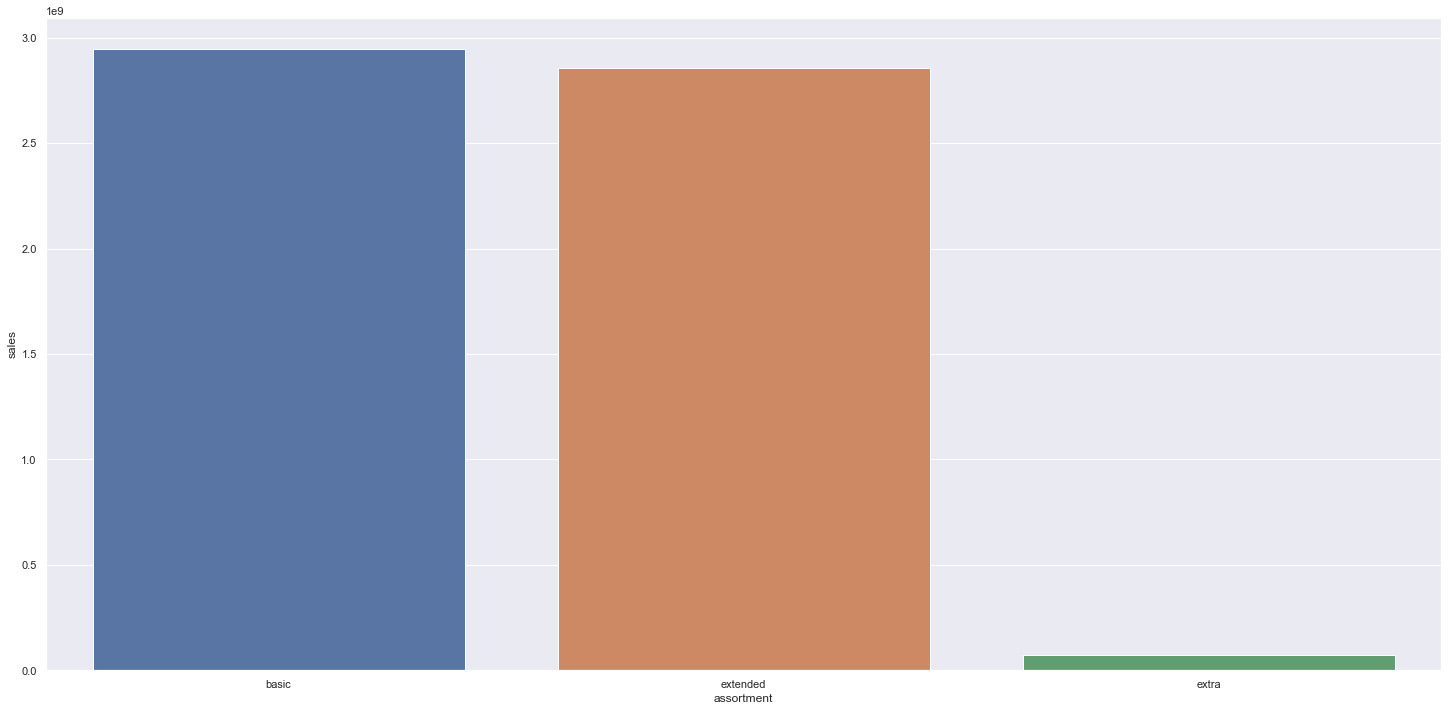

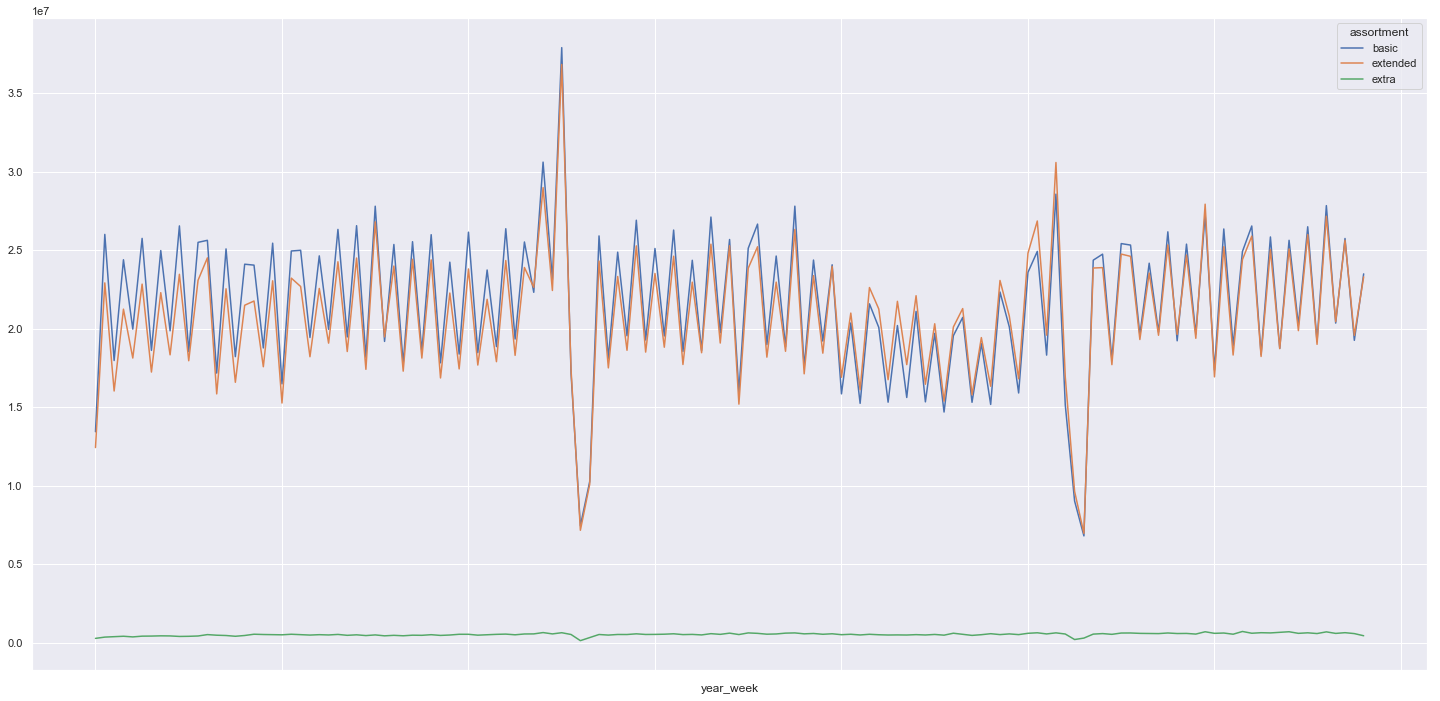

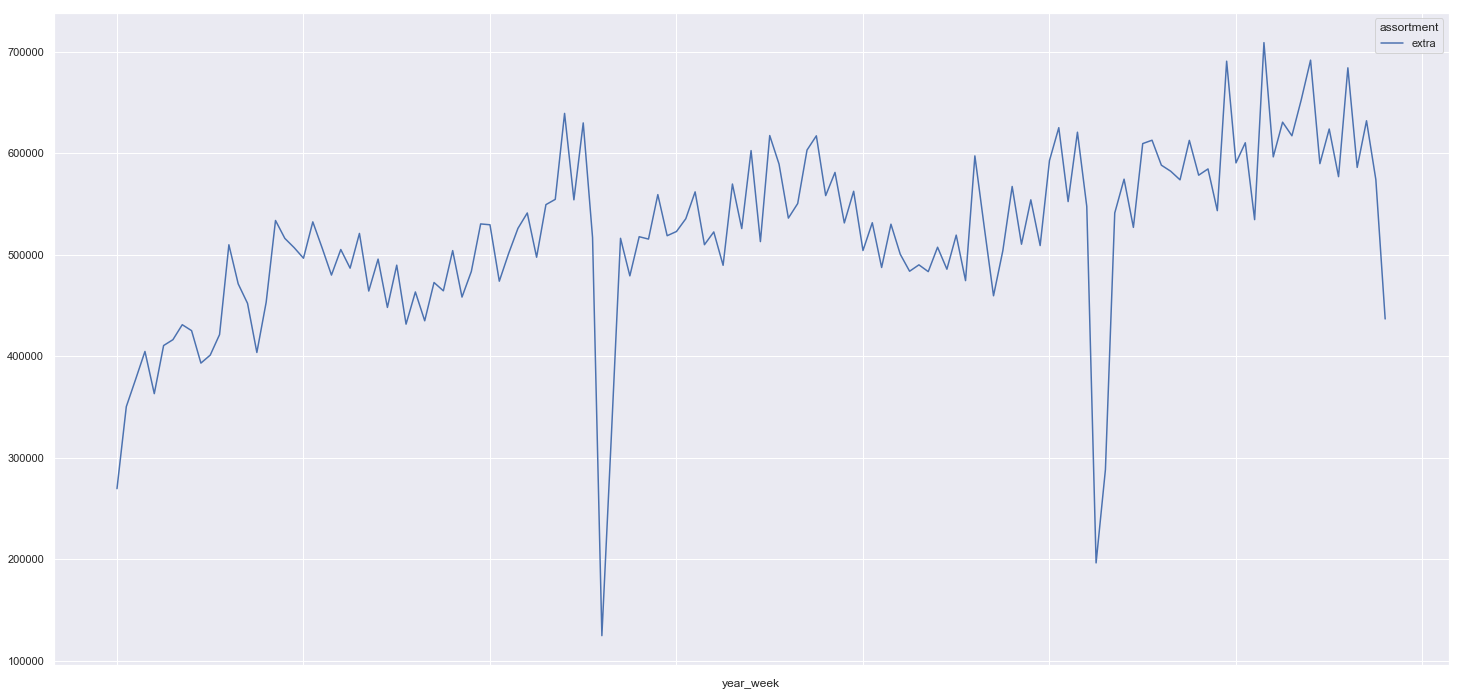

In [55]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2=df4[['year_week', 'assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week',columns='assortment', values='sales').plot()

aux3=aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos
**FALSA** Lojas com COMPETITORES PRÓXIMOS vendem MAIS.

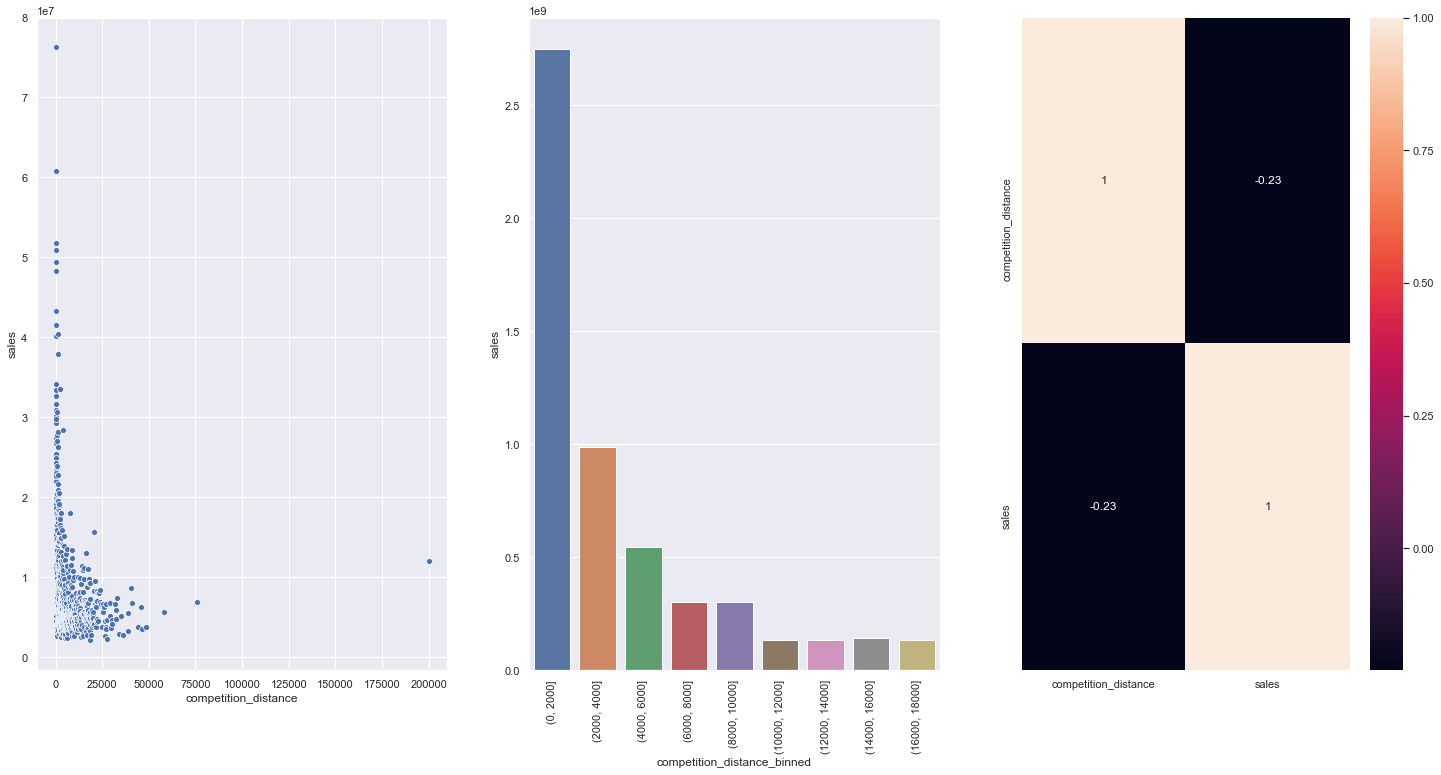

In [56]:
aux4 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales', data=aux4);

plt.subplot(1,3,2)
bins = list(np.arange(0, 20000, 2000))
aux4['competition_distance_binned'] = pd.cut(aux4['competition_distance'], bins=bins)
aux5=aux4[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux5)
plt.xticks(rotation=90);

plt.subplot(1,3,3)
sns.heatmap(aux4.corr(method='pearson'), annot=True);

In [57]:
aux1.head()

,assortment,sales
0,basic,2945750070
1,extended,2856484241
2,extra,70946312


### H3. Lojas com competidores à mais tempo vendem mais.

In [58]:
df4['competition_time_month'] = df4['competition_time_month'].astype(np.int64)

C:\Users\vanessa.paula\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(2.5, -0.5)

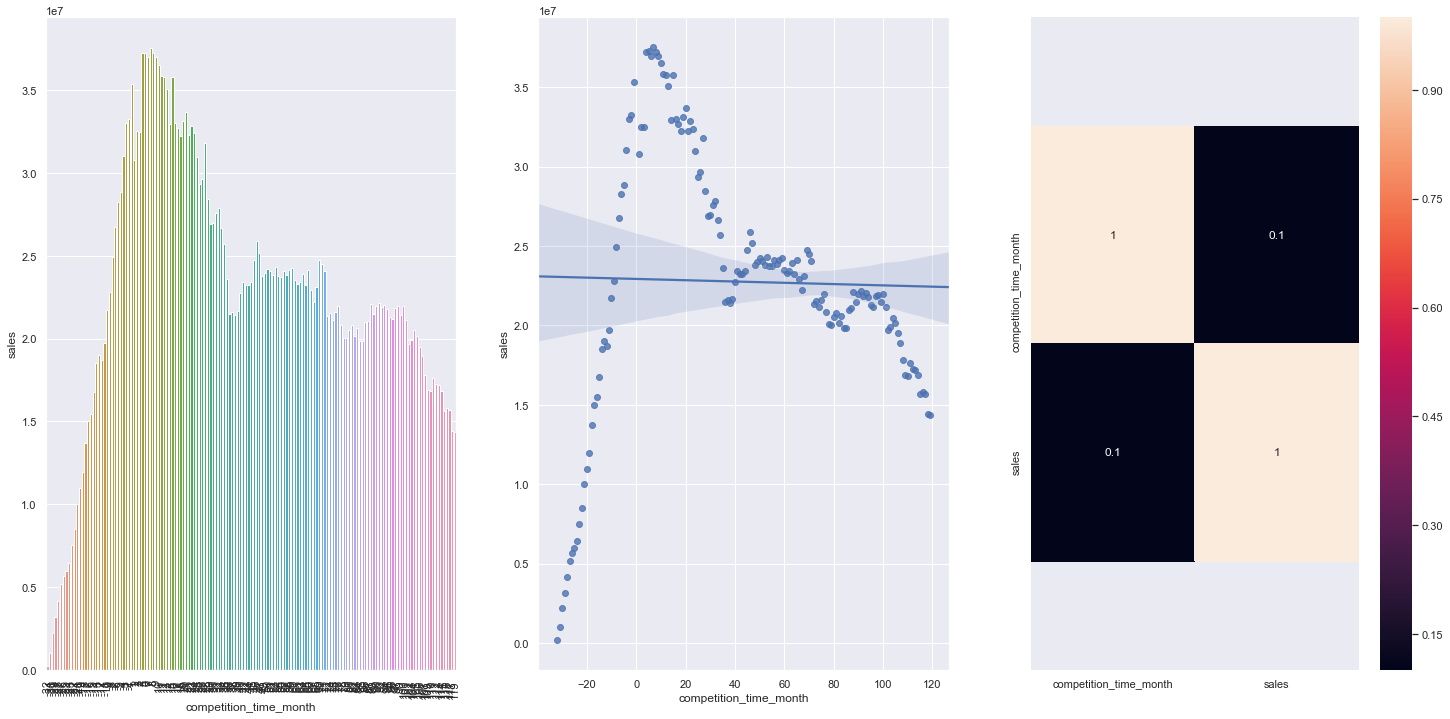

In [59]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[ (aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] !=0 )]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x ='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
x= sns.heatmap(aux1.corr (method='pearson'), annot=True);
bottom, top=x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5)


### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais
***FALSA*** lojas com promoções ativas por mais tempo vendem MENOS depois de um certo tempo.

C:\Users\vanessa.paula\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


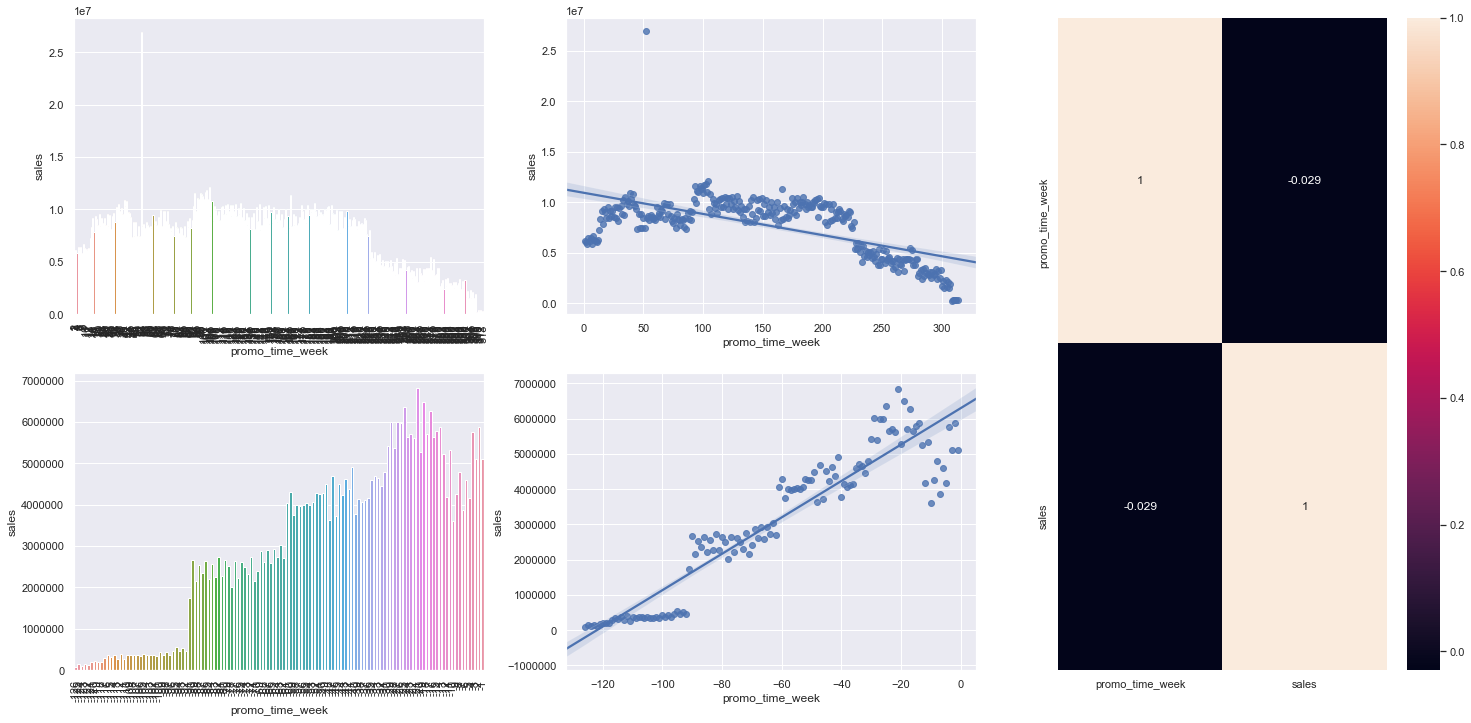

In [64]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']>0] #promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']<0] #promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### H7. lojas com mais promoções consecutivas deveriam vender mais
***FALSA*** Lojas com mais promoções vendem MENOS

In [66]:
df4[['promo', 'promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


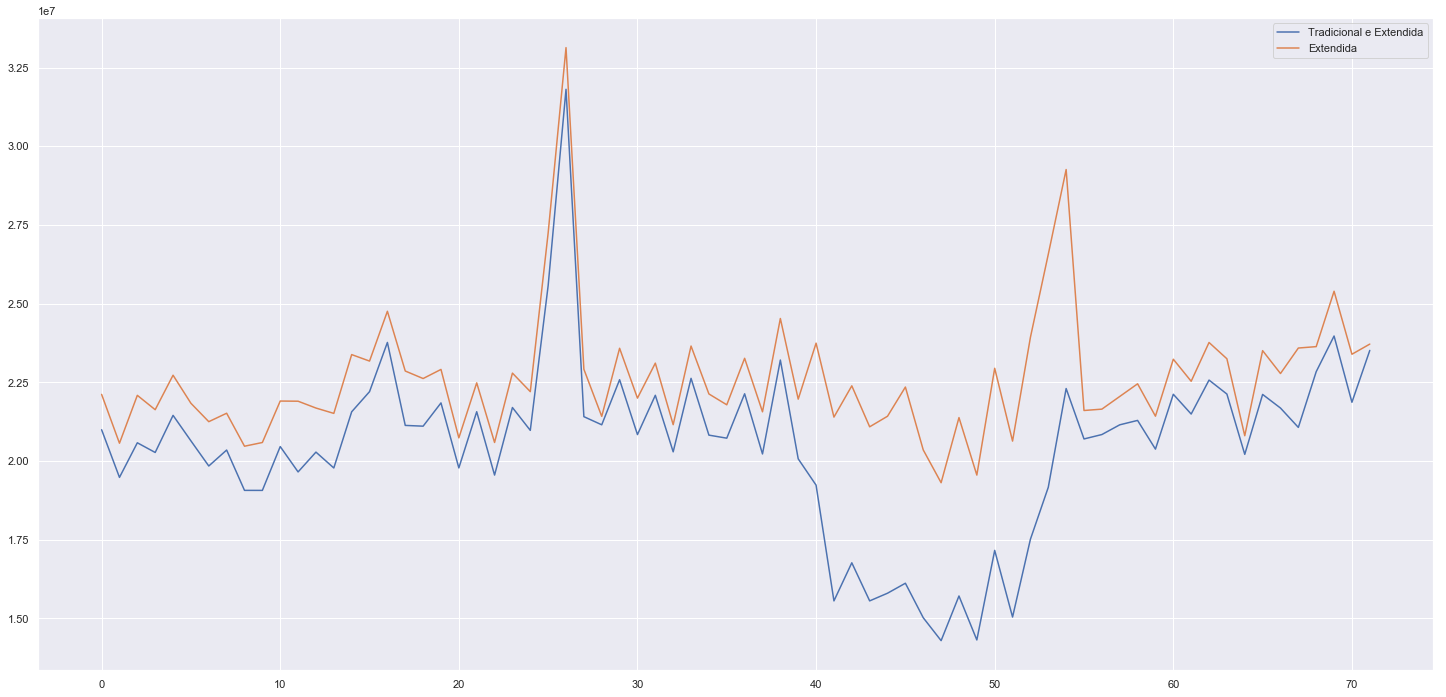

In [68]:
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week', 'sales']].groupby('year_week').sum().reset_index() 
aux2.plot(ax=ax)
ax.legend(labels=['Tradicional e Extendida', 'Extendida'])

In [ ]:
# 